In [2]:
from torch import nn
from torch.nn import functional as F
import torch
import torchvision
import numpy as np
import json
import pandas as pd
import os 
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import glob
import cv2
import torch
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms, datasets
import torch.optim as optim
from torchsummary import summary
import copy
from tqdm.notebook import tqdm
from IPython import display
from mpl_toolkits.axes_grid import ImageGrid

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [3]:
JSON_PATH = "dataset/annotation-small.json"
IMAGE_PATH = "dataset/images/"

In [4]:
annotation_data = None

with open(JSON_PATH, "r") as f: 
    annotation_data = json.load(f)


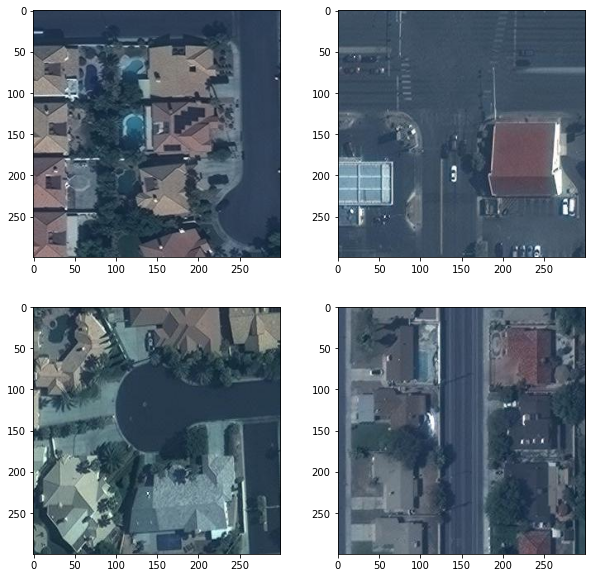

In [5]:
image_df = pd.DataFrame(annotation_data["images"])
image_df.sample(3)
fig, axis = plt.subplots(2, 2, figsize=(10, 10))

for ax, (_, row) in zip(axis.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(IMAGE_PATH, row["file_name"]))
    ax.imshow(img_data)


In [6]:
annotation_df = pd.DataFrame(annotation_data["annotations"])
annotation_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
5313,450510,52659,"[[177.0, 53.0, 165.0, 53.0, 165.0, 77.0, 142.0...",2479.0,"[53.0, 139.0, 124.0, 38.0]",100,0
15655,49987,5857,"[[207, 0, 207, 0, 188, 0, 112, 4, 112, 0, 207,...",150.0,"[0, 112, 207, 95]",100,0
6887,297695,34885,"[[253.0, 217.0, 253.0, 216.0, 232.0, 216.0, 23...",2648.0,"[157.0, 232.0, 103.0, 48.0]",100,0


In [7]:
full_df = pd.merge(
    annotation_df, image_df, how="left", left_on="image_id", right_on="id"
).dropna()
print(image_df.shape[0], "+", annotation_df.shape[0], "->", full_df.shape[0])

full_df.sample(2)


1820 + 15770 -> 15770


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
6072,408749,47825,"[[4.0413344371862654e-15, 183.00000000000003, ...",1869.0,"[4.0413344371862654e-15, 4.0413344371862654e-1...",100,0,47825,000000047825.jpg,300,300
2392,450727,52690,"[[217, 131, 217, 98, 241, 98, 241, 131, 217, 1...",792.0,"[98, 217, 143, 24]",100,0,52690,000000052690.jpg,300,300


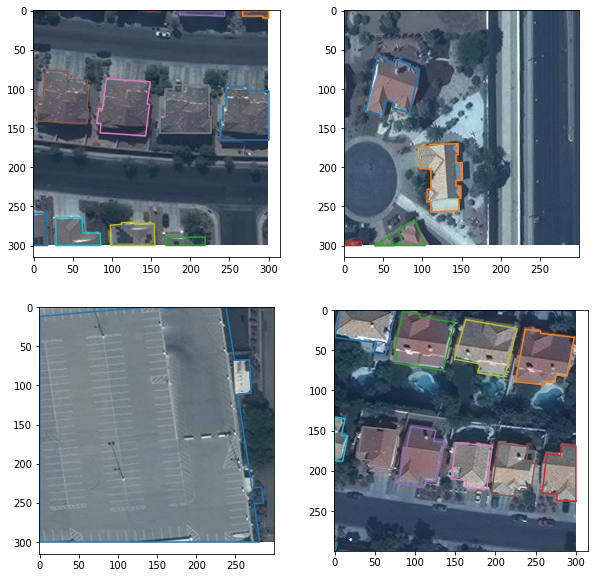

In [8]:
fig, m_axs = plt.subplots(2, 2, figsize=(10, 10))

for ax, (id, df) in zip(m_axs.flatten(), full_df.groupby("image_id")):
    img_data = imread(os.path.join(IMAGE_PATH, df["file_name"].values[0]))
    ax.imshow(img_data)
    for _, row in df.iterrows():
        xy_vec = np.array(row["segmentation"]).reshape((-1, 2))
        ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=df["id_x"])


In [9]:
from matplotlib.path import Path
from skimage.color import label2rgb


def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), range(in_img.shape[1]), indexing="ij")
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row["segmentation"]).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label=c_df["id_x"])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(
            np.stack([yy.ravel(), xx.ravel()], -1)
        ).reshape(out_img.shape)
    return out_img


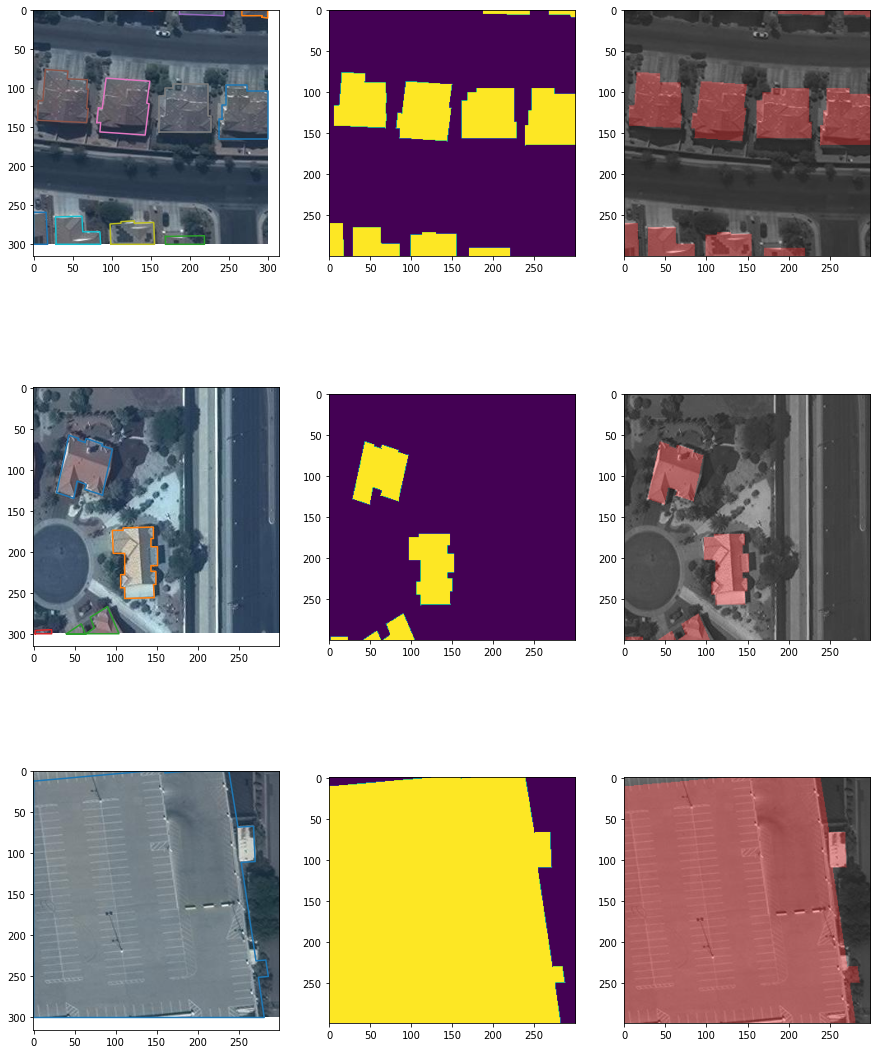

In [10]:
fig, m_axs = plt.subplots(3, 3, figsize=(15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs, full_df.groupby("image_id")):
    img_data = imread(os.path.join(IMAGE_PATH, c_df["file_name"].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    d_ax.imshow(out_img)
    rgba_img = np.concatenate(
        [
            img_data,
            np.clip(np.expand_dims(127 * out_img + 127, -1), 0, 255).astype(np.uint8),
        ],
        -1,
    )
    # d_ax.imshow(rgba_img)

    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label=0))


In [11]:
from sklearn.model_selection import train_test_split

train_ids, valid_ids = train_test_split(image_df["id"], test_size=0.25)
train_df = full_df[full_df["image_id"].isin(train_ids)]
valid_df = full_df[full_df["image_id"].isin(valid_ids)]
print(train_df.shape[0], "training boxes")
print(valid_df.shape[0], "validation boxes")


11803 training boxes
3967 validation boxes


In [12]:
def batch_img_gen(in_df, batch_size):
    all_groups = list(in_df.groupby("image_id"))
    out_img, out_seg = [], []
    while True:
        for (_, c_df) in np.random.permutation(all_groups):
            img_data = imread(os.path.join(IMAGE_PATH, c_df["file_name"].values[0]))
            out_img += [img_data]
            out_seg += [np.expand_dims(rows_to_segmentation(img_data, c_df), -1)]
            if len(out_img) >= batch_size:
                yield (np.stack(out_img, 0) / 255.0).astype(np.float32), np.stack(
                    out_seg, 0
                ).astype(np.float32)
                out_img, out_seg = [], []


valid_gen = batch_img_gen(valid_df, 8)


x (8, 300, 300, 3) float32 0.0 1.0
y (8, 300, 300, 1) float32 0.0 1.0


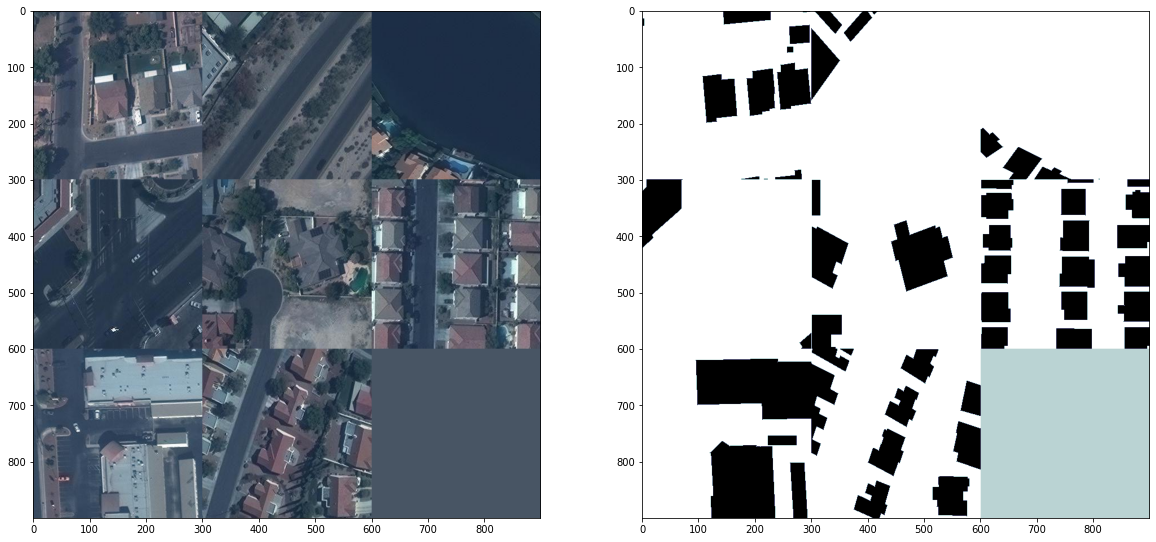

In [14]:
from skimage.util import montage

t_x, t_y = next(valid_gen)
print("x", t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print("y", t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
montage_rgb = lambda x: np.stack(
    [montage(x[:, :, :, i]) for i in range(x.shape[3])], -1
)
ax1.imshow(montage_rgb(t_x))
ax2.imshow(montage(t_y[:, :, :, 0]), cmap="bone_r")


<h1>Unet ResNet model</h1>

In [ ]:
class DecoderBlockV2(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, is_deconv=True):
        super(DecoderBlockV2, self).__init__()
        self.in_channels = in_channels

        if is_deconv:
            """
                Paramaters for Deconvolution were chosen to avoid artifacts, following
                link https://distill.pub/2016/deconv-checkerboard/
            """

            self.block = nn.Sequential(
                ConvRelu(in_channels, middle_channels),
                nn.ConvTranspose2d(middle_channels, out_channels, kernel_size=4, stride=2,
                                   padding=1),
                nn.ReLU(inplace=True)
            )
        else:
            self.block = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ConvRelu(in_channels, middle_channels),
                ConvRelu(middle_channels, out_channels),
            )

    def forward(self, x):
        return self.block(x)

class UNetResNet(nn.Module):
    """PyTorch U-Net model using ResNet(34, 101 or 152) encoder.

    UNet: https://arxiv.org/abs/1505.04597
    ResNet: https://arxiv.org/abs/1512.03385
    Proposed by Alexander Buslaev: https://www.linkedin.com/in/al-buslaev/

    Args:
            encoder_depth (int): Depth of a ResNet encoder (34, 101 or 152).
            num_classes (int): Number of output classes.
            num_filters (int, optional): Number of filters in the last layer of decoder. Defaults to 32.
            dropout_2d (float, optional): Probability factor of dropout layer before output layer. Defaults to 0.2.
            pretrained (bool, optional):
                False - no pre-trained weights are being used.
                True  - ResNet encoder is pre-trained on ImageNet.
                Defaults to False.
            is_deconv (bool, optional):
                False: bilinear interpolation is used in decoder.
                True: deconvolution is used in decoder.
                Defaults to False.

    """

    def __init__(
        self,
        encoder_depth,
        num_classes,
        num_filters=32,
        dropout_2d=0.2,
        pretrained=False,
        is_deconv=False,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.dropout_2d = dropout_2d

        if encoder_depth == 34:
            self.encoder = torchvision.models.resnet34(pretrained=pretrained)
            bottom_channel_nr = 512
        elif encoder_depth == 101:
            self.encoder = torchvision.models.resnet101(pretrained=pretrained)
            bottom_channel_nr = 2048
        elif encoder_depth == 152:
            self.encoder = torchvision.models.resnet152(pretrained=pretrained)
            bottom_channel_nr = 2048
        else:
            raise NotImplementedError(
                "only 34, 101, 152 version of Resnet are implemented"
            )

        self.pool = nn.MaxPool2d(2, 2)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(
            self.encoder.conv1, self.encoder.bn1, self.encoder.relu, self.pool
        )

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4

        self.center = DecoderBlockV2(
            bottom_channel_nr, num_filters * 8 * 2, num_filters * 8, is_deconv
        )
        self.dec5 = DecoderBlockV2(
            bottom_channel_nr + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec4 = DecoderBlockV2(
            bottom_channel_nr // 2 + num_filters * 8,
            num_filters * 8 * 2,
            num_filters * 8,
            is_deconv,
        )
        self.dec3 = DecoderBlockV2(
            bottom_channel_nr // 4 + num_filters * 8,
            num_filters * 4 * 2,
            num_filters * 2,
            is_deconv,
        )
        self.dec2 = DecoderBlockV2(
            bottom_channel_nr // 8 + num_filters * 2,
            num_filters * 2 * 2,
            num_filters * 2 * 2,
            is_deconv,
        )
        self.dec1 = DecoderBlockV2(
            num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv
        )
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)

    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)

        pool = self.pool(conv5)
        center = self.center(pool)

        dec5 = self.dec5(torch.cat([center, conv5], 1))

        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)

        return self.final(F.dropout2d(dec0, p=self.dropout_2d))


<h1>Dataset preperation </h1>

In [ ]:
class PersonData2(Dataset):
    def __init__(
        self, image_paths, label_paths, image_transform=None, label_transform=None
    ):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.image_transform = image_transform
        self.label_transform = label_transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.label_paths[idx]
        label = cv2.cvtColor(cv2.imread(label_path), cv2.COLOR_BGR2RGB)
        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        image = self.image_transform(image)
        label = self.label_transform(label)
        return image, label


In [ ]:
data_transforms = {
    "image": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            transforms.Resize((rows, cols)),
        ]
    ),
    "label": transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((rows, cols)),
            transforms.Grayscale(1),
        ]
    ),
}

image_paths = glob.glob("person_dataset/images/*.jpg")
label_paths = glob.glob("person_dataset/labels/*.jpg")
train_split = int(0.8 * len(image_paths))

# train_split = 1000

task3_datasets = {
    "train": PersonData2(
        image_paths[:train_split],
        label_paths[:train_split],
        data_transforms["image"],
        data_transforms["label"],
    ),
    "val": PersonData2(
        image_paths[train_split:],
        label_paths[train_split:],
        data_transforms["image"],
        data_transforms["label"],
    ),
}


dataloaders = {
    phase: DataLoader(task3_datasets[phase], BATCHSIZE, shuffle=True, num_workers=0)
    for phase in ["train", "val"]
}


# Training Pipline


In [ ]:
def train_model(model, dataloaders, criterion, optimizer, weight_path, num_epochs=25):
    val_loss_history = []
    train_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    last_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1000000.0

    for epoch in tqdm(range(num_epochs)):
        print(f"Epoch {epoch} / {num_epochs - 1}", end="\t")

        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            elif phase == "val":
                model.eval()

            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f"{phase} loss: {epoch_loss:.4f}", end="\t")

            if phase == "val" and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_best.pt")

            if phase == "val":
                val_loss_history.append(epoch_loss)
                last_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, f"{weight_path}_last.pt")

            if phase == "train":
                train_loss_history.append(epoch_loss)

        print()

    print("-" * 30)
    print(f"Training Complete")
    print(f"Best Validation Loss: {best_loss:.4f}")

    return best_model_wts, val_loss_history, train_loss_history


In [ ]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(completionModel.parameters(), lr=LEARNING_RATE)

best_wts, hist = train_model(
    completionModel, dataloaders, loss_function, optimizer, EPOCHS
)

# torch.save(best_wts, "task1_weights")
torch.save(best_wts, "building_seg  _weights")